In [1]:
# Load libraries
import pandas as pd
from sklearn import linear_model 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, balanced_accuracy_score
#from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score


In [5]:
# Define functions

def Filter_low_Expr(arr):
    
    #input: arr: a list of expression values for a gene across all samples
    #output: True or False that indicates whether this gene show expression greater than 0 in more than 50% of the samples
    
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)

def train_test_split_gq(df_sele, binary_cutoff, test_size): #stratified sampling
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)
def model_run_with_Independent_crossvalidation(train_data,test_data, train_labels, test_labels, independent_labels, independent_features,random_): #modified at 11:46 AM Feb 15
    result_summary = {}
    
    if len(independent_labels) <= 1:
        return(result_summary)
    
    xgb_model = xgb.XGBClassifier(n_jobs=4)
    clf = GridSearchCV(xgb_model, {#'max_depth': [2],
                                   'max_depth': [2,3,4],
                                   'n_estimators': [100], 
                                   'learning_rate': [0.05, 0.1],
                                   #'gamma':[1],
                                   #'eta':[0.2,0.3,0.4],
                                  # 'min_child_weight':[1,2],
                                  # 'lambda':[1,2],
                                  # 'subsample':[0.8]
                                  },
                                  refit=True, 
                                  verbose=0, 
                                  cv=5, 
                                  n_jobs=4, 
                                  return_train_score=True,
                                  scoring = 'balanced_accuracy') #5-fold cross validation

    clf.fit(train_data, train_labels.values)

    print("clf.best_score_: balanced_accuracy: ")
    print(clf.best_score_) #Train data

    print("clf.best_params_:")
    para = (clf.best_params_)
    print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=1, learning_rate = para['learning_rate'], 
                                  max_depth=para['max_depth'], 
                                  n_estimators=para['n_estimators'])
    
    xgb_model.fit(train_data,train_labels.values)



    #blanced_acc_traing = clf.best_score_
    #print("blanced_acc_traing:" + str(blanced_acc_traing))
    #acc_traing = accuracy_score(train_labels, predictions_training)
    #print("acc_traing:" + str(acc_traing))
    #f1_traing = f1_score(list(train_labels), predictions_training)
    #print("f1_traing:" + str(f1_traing))

    predictions = clf.predict(test_data)
    predictions_independent = clf.predict(independent_features)
    
    accuracy = accuracy_score(test_labels, predictions)
    print("accuracy_test_w1/2:" + str(accuracy))
    blanced_acc = balanced_accuracy_score(test_labels, predictions) #(sensitivity + specificity) /2 
    print("balanced_accuracy_test_w1/2:" + str(blanced_acc))
    f1 = f1_score(test_labels, predictions)
    print("f1_test_w1/2:" + str(f1))

    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    #accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    print("f1_independent:" + str(f1_independent))
    blanced_acc_independent = balanced_accuracy_score(independent_labels, predictions_independent) #(sensitivity_independent + specificity_independent) /2 
    print("blanced_acc_independent:" + str(blanced_acc_independent))

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    
    result_summary['random_state'] = random_
    result_summary['best_params'] = clf.best_params_

    
    #result_summary['F1_score_training'] = f1_traing
    result_summary['balanced_acc_training'] = clf.best_score_
    
    result_summary['Accuracy'] = accuracy #1
    
    result_summary['F1_score'] = f1 #4
    
    result_summary['balanced_acc'] = blanced_acc #6
    
    
    
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    result_summary['F1_score_independent'] = f1_independent #6
    
    result_summary['features'] = result_feature
    return(result_summary)

def select_duplicated_col(my_list):
    duplicates = []
    for item in my_list:
        if my_list.count(item) > 1:
            if item not in duplicates:
                duplicates.append(item)
    return(duplicates)

In [6]:
# Load data
# Gene expression from BeatAML wave 1 and 2
Drug_data = pd.read_csv("../../../Data_resource/Drug_Response.csv",index_col = "Unnamed: 0") 


GE = pd.read_csv("../../../Data_resource/RPKM.csv",index_col = "Unnamed: 0")
data_all  = pd.read_csv("./beatAML_wave1_2_feature_ic50_highExpr.csv", index_col= "Unnamed: 0")
mut_w1_2 = data_all.iloc[:,0:22].dropna()


# Load testing data from BeatAML wave 1-4
BeatAML_wave_3_expr = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/rnaseq/beataml_waves1to4_allnorm.txt", sep = "\t") 
BeatAML_wave_3_drugResponse = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/inhibitor/beataml_probit_curve_fits_v4_distr_nonproprietary.txt", sep = "\t")
BeatAML_mut_matrix_sele_w3_4 = pd.read_csv("/Users/guangrong/Documents/Datasets/AML/BeatAML-wave1-4/Beat AML collaborator files Waves 1-4/BeatAML_mut_matrix_sele_w3_4.csv", index_col = "Unnamed: 0")

In [7]:
#Formating gene expression data for training data
GE.index = GE['Gene']
gene_list_w12 = (list(GE.index))
sample_list_w12 = list(set(GE.columns) - set(['Gene','Symbol']))
input_data = GE.loc[list(gene_list_w12), sample_list_w12]


#Formating gene expression data for testing data
BeatAML_wave_3_expr.index = BeatAML_wave_3_expr['stable_id']
gene_list = (list(BeatAML_wave_3_expr.index))
sample_list = list(set(BeatAML_wave_3_expr.columns) - set(['stable_id','display_label','description','biotype']) - set(sample_list_w12))
input_data_test = BeatAML_wave_3_expr.loc[list(gene_list), sample_list]

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]


In [95]:
Drugs = pd.read_csv("/Users/guangrong/Documents/GitHub_project/AML_BeatAML/Manuscript/Supplemental_Tables/Supplemental_1_Number_of_effective_cases.csv")

Drugs = list(Drugs['Drug'])
print(Drugs)
print(len(Drugs))

Drugs_remain = set(Drugs) - set(["PI-103", "PP242", "Venetoclax", "SNS-032 (BMS-387032)", "Foretinib (XL880)", 
"BEZ235","JNJ-28312141","Elesclomol","Quizartinib (AC220)","Trametinib (GSK1120212)","Flavopiridol", "INK-128",
"Dovitinib (CHIR-258)", "Doramapimod (BIRB 796)", "Rapamycin", "Panobinostat", "Selumetinib (AZD6244)"])
print(len(Drugs_remain))

['Elesclomol', 'Trametinib (GSK1120212)', 'Ponatinib (AP24534)', 'INK-128', 'Dasatinib', 'Panobinostat', 'JNJ-28312141', 'Rapamycin', 'Foretinib (XL880)', 'Quizartinib (AC220)', 'Venetoclax', 'Sunitinib', 'Dovitinib (CHIR-258)', 'Doramapimod (BIRB 796)', 'PI-103', 'SNS-032 (BMS-387032)', 'Selumetinib (AZD6244)', 'Flavopiridol', 'BEZ235', 'PP242', 'Gilteritinib (ASP-2215)', 'KI20227', 'JAK Inhibitor I', 'Tivozanib (AV-951)', 'Bortezomib (Velcade)', 'Lestaurtinib (CEP-701)', 'Midostaurin', 'Idelalisib', 'Cabozantinib', 'MK-2206', 'Sorafenib', 'Selinexor', '17-AAG (Tanespimycin)', 'Crenolanib', 'GDC-0941', 'KW-2449', 'RAF265 (CHIR-265)', 'MGCD-265', 'JQ1', 'Pelitinib (EKB-569)', 'CHIR-99021', 'Masitinib (AB-1010)', 'NF-kB Activation Inhibitor', 'CI-1040 (PD184352)', 'GSK690693', 'Neratinib (HKI-272)', 'NVP-TAE684', 'CYT387', 'S31-201', 'Ibrutinib (PCI-32765)', 'VX-745', 'A-674563', 'ABT-737', 'Axitinib (AG-013736)', 'Vandetanib (ZD6474)', 'Bosutinib (SKI-606)', 'Vargetef', 'Pazopanib (GW7

In [16]:
input_data.shape #[gene expression for 451 samples in beatAML dataset wave 1/2]
input_data_test.shape # gene expression for 256 samples in beatAML wave 3/
#input_data_test


(23150, 256)

In [58]:
threshold_previous = pd.read_csv("Accuracy_matrix_Jun22_2023.csv")

In [62]:
threshold_previous
dic_threshold = {}
for i in range(0,threshold_previous.shape[0]):
    drug = threshold_previous.iloc[i,1]
    threshold = threshold_previous.iloc[i,2]
    if drug not in dic_threshold:
        dic_threshold[drug] = threshold
    

In [96]:
# Run the model
#Drug = "Venetoclax"
result_with_threshod = {}
#for Drug in Drugs:
for Drug in Drugs_remain:
#for Drug in ["Venetoclax"]:
    print("********************************************************")
    print(Drug)
    print("********************************************************")
    
    #new_feature_df_t,new_feature_df_test = features(Drug, KG_expr_resp,KG_reg,dic_gene_map, input_data, input_data_test, BeatAML_mut_matrix_sele_w3_4, mut_w1_2, sele_house_keeping )
    result_with_threshod[Drug] = {}
    # Formatting trainning data
    Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
    Drug_sele_df.index = Drug_sele_df['lab_id']
    Drug_sele_df =Drug_sele_df.loc[:,['ic50']]
    Drug_sele_df

    feature_training = input_data.transpose() #
    feature_testing = input_data_test.transpose() #
    feature_common = set(feature_training.columns).intersection(set(feature_testing.columns))
    feature_common = list(feature_common)

    feature_training = feature_training.loc[:,feature_common]
    feature_testing = feature_testing.loc[:,feature_common]
    
    df_sele = pd.concat([feature_training, Drug_sele_df],axis = 1)
    df_sele = df_sele.dropna()
        
    # Formatting testing data using beatAML wave 3/4
    Drug_sele_df_wave3 = BeatAML_wave_3_drugResponse.loc[BeatAML_wave_3_drugResponse['inhibitor'] == Drug]
    Drug_sele_df_wave3.index = Drug_sele_df_wave3['lab_id']
    Drug_sele_df_wave3 =Drug_sele_df_wave3.loc[:,['ic50']]


    df_sele__wave3 = pd.concat([feature_testing, Drug_sele_df_wave3],axis = 1)
    df_sele__wave3 = df_sele__wave3.dropna()

    #df_sele__wave3.head(3)
    #df_sele__wave3.shape
    
    #q10 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
    q25 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
    q50 = np.quantile(Drug_sele_df['ic50'].values, q = 0.5)
    q75 = np.quantile(Drug_sele_df['ic50'].values, q = 0.75)

    threshold_list_label = []
    threshold_list = []
    if q25 < 10:
        threshold_list.append(q25)
        threshold_list_label.append("Q25:" + str(round(q25,2)) + "μM")
    if (q50 < 10 and q50 > q25):
        threshold_list.append(q50)
        threshold_list_label.append("Q50:" + str(round(q50,2)) + "μM")
    if (q75 < 10 and q75 > q50):
        threshold_list.append(q75)
        threshold_list_label.append("Q75:" + str(round(q75,2)) + "μM")
    #if q75 < 1:
    #    threshold_list.append(1)

    if len(threshold_list) >0:
        if max(threshold_list) < 1:
            threshold_list.append(1)
            threshold_list_label.append("1μM")
   # else:
   #     threshold_list.append(1)
   #     threshold_list_label.append("1μM")
        
    #if q75 < 1:
    threshold_list = list(set(threshold_list))

    if q25 > 10:
        print(Drug + ": high IC50")
        continue
    #print(threshold_list)
    
    #for Threshod in threshold_list:
    if Drug in dic_threshold:
        selected_threshold_curr_drug = [dic_threshold[Drug]]

        for Threshold in selected_threshold_curr_drug:
            print("Threshod" + str(Threshod))
            data_cur = df_sele # Step 1
            data_cur = data_cur.dropna()
            new_label = []
            for i in data_cur['ic50'].values:
                if i <= Threshod:
                    new_label.append(1)
                else:
                    new_label.append(0)
            data_cur[Drug+"_bi"] = new_label

            df_sele__wave3_cur = df_sele__wave3
            new_label = []
            for i in df_sele__wave3_cur['ic50'].values:
                if i <= Threshod:
                    new_label.append(1)
                else:
                    new_label.append(0)
            df_sele__wave3_cur[Drug+"_bi"] = new_label

            result_all = {}
            result_all_test_w3 = {}

            for random_ in range(0,100,10): 
                print("======================================================")
                sensitive_data = data_cur.loc[data_cur[Drug+"_bi"] == 1]
                resistant_data = data_cur.loc[data_cur[Drug+"_bi"] == 0]
                
                if (sensitive_data.shape[0] > 0 and resistant_data.shape[0] > 0):
                    

                    train_data_sen, test_data_sen, train_labels_sen, test_labels_sen = train_test_split(sensitive_data.iloc[:,:-2], 
                                                                                        sensitive_data.iloc[:,-1],
                                                                                        test_size = 0.2, random_state = random_)
                    train_data_res, test_data_res, train_labels_res, test_labels_res = train_test_split(resistant_data.iloc[:,:-2], 
                                                                                        resistant_data.iloc[:,-1],
                                                                                        test_size = 0.2, random_state = random_)

                    train_data = pd.concat([train_data_sen, train_data_res])
                    train_labels = pd.concat([train_labels_sen, train_labels_res])
                    
                    
                    test_data = pd.concat([test_data_sen, test_data_res])
                    test_labels = pd.concat([test_labels_sen, test_labels_res])
                    print(test_data.shape)
                    
                    test_w3_labels = df_sele__wave3_cur[Drug+"_bi"]
                    test_w3_features = df_sele__wave3_cur.iloc[:,:-2]
                    print(test_w3_features.shape)
                    
                    duplicated_list_training = select_duplicated_col(list(train_data.columns))
                    unique_list_training = list(set(list(train_data.columns)) - set(duplicated_list_training))
                    
                    if len(duplicated_list_training) > 0:
                        
                        for col in duplicated_list_training:
                            train_data = train_data.loc[:, ~train_data.columns.duplicated()]
                            test_data = test_data.loc[:, ~test_data.columns.duplicated()]
                            test_w3_features = test_w3_features.loc[:,~test_w3_features.columns.duplicated()]
                            df_sele__wave3_cur = df_sele__wave3_cur.loc[:,~df_sele__wave3_cur.columns.duplicated()]
                            
                    if test_w3_features.shape[0] > 0:
                        result_all[random_] = model_run_with_Independent_crossvalidation(train_data,test_data, train_labels, test_labels, df_sele__wave3_cur[Drug+"_bi"],  df_sele__wave3_cur.iloc[:,:-2],random_)

            result_with_threshod[Drug][Threshod] = result_all


********************************************************
NVP-TAE684
********************************************************
Threshod1.45261900330956
(58, 22761)
(166, 22761)
clf.best_score_: balanced_accuracy: 
0.6235176651305684
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
accuracy_test_w1/2:0.7241379310344828
balanced_accuracy_test_w1/2:0.6329284750337382
f1_test_w1/2:0.4666666666666667
f1_independent:0.481203007518797
blanced_acc_independent:0.5695022345507783
(58, 22761)
(166, 22761)
clf.best_score_: balanced_accuracy: 
0.6084946236559141
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
accuracy_test_w1/2:0.8103448275862069
balanced_accuracy_test_w1/2:0.7375168690958165
f1_test_w1/2:0.6451612903225806
f1_independent:0.42028985507246375
blanced_acc_independent:0.5068577592849437
(58, 22761)
(166, 22761)
clf.best_score_: balanced_accuracy: 
0.6214132104454685
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 4, 'n_e

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
(16, 22761)
(164, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


clf.best_score_: balanced_accuracy: 
0.6
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.875
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.9333333333333333
f1_independent:0.9781931464174455
blanced_acc_independent:0.5
********************************************************
Tozasertib (VX-680)
********************************************************
Threshod1.45261900330956
(58, 22761)
(168, 22761)
clf.best_score_: balanced_accuracy: 
0.5923717948717948
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
accuracy_test_w1/2:0.8448275862068966
balanced_accuracy_test_w1/2:0.5453514739229025
f1_test_w1/2:0.1818181818181818
f1_independent:0.27999999999999997
blanced_acc_independent:0.5728744939271255
(58, 22761)
(168, 22761)
clf.best_score_: balanced_accuracy: 
0.5688644688644688
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.8275862068965517
balanced_accuracy_

/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.54
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.7058823529411765
balanced_accuracy_test_w1/2:0.5480769230769231
f1_test_w1/2:0.8148148148148148
f1_independent:0.5
blanced_acc_independent:0.3333333333333333
(17, 22761)
(3, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.6366666666666666
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.7058823529411765
balanced_accuracy_test_w1/2:0.46153846153846156
f1_test_w1/2:0.8275862068965517
f1_independent:0.5
blanced_acc_independent:0.3333333333333333
(17, 22761)
(3, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.58
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.8235294117647058
balanced_accuracy_test_w1/2:0.7115384615384616
f1_test_w1/2:0.888888888888889
f1_independent:0.0
blanced_acc_independent:0.0
(17, 22761)
(3, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.56
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.7058823529411765
balanced_accuracy_test_w1/2:0.5480769230769231
f1_test_w1/2:0.8148148148148148
f1_independent:0.5
blanced_acc_independent:0.3333333333333333
(17, 22761)
(3, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.5166666666666666
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.7647058823529411
balanced_accuracy_test_w1/2:0.5
f1_test_w1/2:0.8666666666666666
f1_independent:0.5
blanced_acc_independent:0.3333333333333333
(17, 22761)
(3, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.6333333333333332
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.8235294117647058
balanced_accuracy_test_w1/2:0.7115384615384616
f1_test_w1/2:0.888888888888889
f1_independent:0.0
blanced_acc_independent:0.0
(17, 22761)
(3, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.52
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.7647058823529411
balanced_accuracy_test_w1/2:0.5865384615384616
f1_test_w1/2:0.8571428571428571
f1_independent:0.5
blanced_acc_independent:0.3333333333333333
(17, 22761)
(3, 22761)


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


clf.best_score_: balanced_accuracy: 
0.6183333333333333
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.6470588235294118
balanced_accuracy_test_w1/2:0.4230769230769231
f1_test_w1/2:0.7857142857142856
f1_independent:1.0
blanced_acc_independent:1.0
(17, 22761)
(3, 22761)
clf.best_score_: balanced_accuracy: 
0.5466666666666666
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
accuracy_test_w1/2:0.7647058823529411
balanced_accuracy_test_w1/2:0.5865384615384616
f1_test_w1/2:0.8571428571428571
f1_independent:0.0
blanced_acc_independent:0.0
********************************************************
Pazopanib (GW786034)
********************************************************


/Users/guangrong/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Threshod1.45261900330956
(63, 22761)
(163, 22761)
clf.best_score_: balanced_accuracy: 
0.5277439024390244
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
accuracy_test_w1/2:0.8095238095238095
balanced_accuracy_test_w1/2:0.49038461538461536
f1_test_w1/2:0.0
f1_independent:0.0
blanced_acc_independent:0.4959349593495935
(63, 22761)
(163, 22761)
clf.best_score_: balanced_accuracy: 
0.5353048780487806
clf.best_params_:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
accuracy_test_w1/2:0.8095238095238095
balanced_accuracy_test_w1/2:0.49038461538461536
f1_test_w1/2:0.0
f1_independent:0.0
blanced_acc_independent:0.5
(63, 22761)
(163, 22761)
clf.best_score_: balanced_accuracy: 
0.5076219512195121
clf.best_params_:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
accuracy_test_w1/2:0.8095238095238095
balanced_accuracy_test_w1/2:0.49038461538461536
f1_test_w1/2:0.0
f1_independent:0.0
blanced_acc_independent:0.5
(63, 22761)
(163, 22761)
clf.bes

In [107]:
Drug_list = []
Value_list = []
Type_list = []
Threshold_list = []
ACC_training_list = []
F1_training_list = []
sensitivity_training_list = []
specificity_training_list = []

ACC_list = []
ACC_independent_test_list = []
F1_list = []
F1_independent_test_list = []
sensitivity_list = []
sensitivity_independent_list = []
specificity_list = []
specificity_independent_list = []

for Drug in result_with_threshod:
    for Threshod in  result_with_threshod[Drug]:
        for random_state in result_with_threshod[Drug][Threshod]:
            if "sensitivity" in result_with_threshod[Drug][Threshod][random_state]:
                sensitivity_list.append(result_with_threshod[Drug][Threshod][random_state]['sensitivity'])
            
            if "balanced_acc_training" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_training_list.append(result_with_threshod[Drug][Threshod][random_state]['balanced_acc_training'])
            
            if "F1_score_training" in result_with_threshod[Drug][Threshod][random_state]:
                F1_training_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score_training'])
                
            if "balanced_acc" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_list.append(result_with_threshod[Drug][Threshod][random_state]['balanced_acc'])

            if "blanced_acc_independent" in result_with_threshod[Drug][Threshod][random_state]:
                ACC_independent_test_list.append(result_with_threshod[Drug][Threshod][random_state]['blanced_acc_independent'])

            if "F1_score" in result_with_threshod[Drug][Threshod][random_state]:
                F1_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score'])
                
            if "F1_score_independent" in result_with_threshod[Drug][Threshod][random_state]:
                F1_independent_test_list.append(result_with_threshod[Drug][Threshod][random_state]['F1_score_independent'])

                Threshold_list.append(Threshod)
                Drug_list.append(Drug)


In [108]:
# get the threshold for one drug
r = pd.DataFrame({"Drug":Drug_list, 
                  "Threshold":Threshold_list, 
                  "ACC_train": ACC_training_list,
                  #"F1_train":F1_training_list,
                  "ACC1_2":ACC_list,
                  "ACC_w3_4":ACC_independent_test_list,
                  "F1_w1_2":F1_list, 
                  "F1_w3_4":F1_independent_test_list})
#data = r.loc[r['Threshold'] == 0.2]

sele_threshold = {}
for drug in set(r['Drug']):
    #print(drug)
    cur = r[r['Drug'] == drug]
    #x = y = z = 0 
    max_acc = 0
    
    for threshold in set(cur['Threshold']):
        x = np.median(cur.loc[cur['Threshold'] == threshold]['ACC_w3_4'].values) 
        if x > max_acc:
            max_acc = x
            sele_threshold[drug] = threshold


In [109]:
selected_r = pd.DataFrame()
for Drug in set(sele_threshold):
    r_cur_drug = r.loc[r['Drug'] == Drug]
    r_cur_drug_sele = r_cur_drug.loc[r_cur_drug['Threshold'] ==sele_threshold[Drug] ]
    
    selected_r = pd.concat([selected_r,r_cur_drug_sele])

In [ ]:
selected_r1 = pd.read_csv("Accuracy_matrix_Jun23_2023_expression.csv", index_col = "Unnamed: 0")
selected_r_test = pd.concat([selected_r,selected_r1])
selected_r = selected_r_test

In [146]:
selected_r.to_csv("Accuracy_matrix_Jun23_2023_expression_all.csv")

In [141]:
result_final = pd.DataFrame()
Drug_list_sele = []
median_f1 = []
#for drug in sele_threshold:
for drug in set(selected_r['Drug']):
    print(drug)
    cur = selected_r[selected_r['Drug'] == drug]
    median_f1.append(np.median(cur['ACC1_2']))
    Drug_list_sele.append(drug)

   # result_final = pd.concat([result_final, selected_r.loc[selected_r['Threshold']==sele_threshold[drug]]])

NVP-TAE684
Axitinib (AG-013736)
TG101348
Venetoclax
Midostaurin
Lapatinib
Linifanib (ABT-869)
Crizotinib (PF-2341066)
JNJ-28312141
Pazopanib (GW786034)
Elesclomol
Trametinib (GSK1120212)
JQ1
Masitinib (AB-1010)
Flavopiridol
Entospletinib (GS-9973)
Cediranib (AZD2171)
GDC-0941
AT7519
Tivozanib (AV-951)
Canertinib (CI-1033)
PP242
Panobinostat
VX-745
PI-103
NF-kB Activation Inhibitor
Volasertib (BI-6727)
RAF265 (CHIR-265)
Selinexor
Vandetanib (ZD6474)
NVP-ADW742
Quizartinib (AC220)
Tozasertib (VX-680)
Tofacitinib (CP-690550)
Lovastatin
Vatalanib (PTK787)
Lenvatinib
Rapamycin
Selumetinib (AZD6244)
Bortezomib (Velcade)
17-AAG (Tanespimycin)
Foretinib (XL880)
AZD1480
PRT062607
CI-1040 (PD184352)
Cabozantinib
GSK-1838705A
PD173955
KI20227
Vargetef
Sorafenib
KW-2449
MGCD-265
Bosutinib (SKI-606)
Imatinib
INK-128
Dovitinib (CHIR-258)
Crenolanib
Doramapimod (BIRB 796)
ABT-737
Neratinib (HKI-272)
A-674563
SNS-032 (BMS-387032)
Motesanib (AMG-706)
Idelalisib
BEZ235
MK-2206
PHA-665752
JAK Inhibitor I

In [143]:
order_drugs = pd.DataFrame({'Drug':Drug_list_sele, 
                            'F1':median_f1, 
                            "category":["Drug"]*len(Drug_list_sele)}).sort_values(by = ['F1'], ascending = False)

In [144]:
selected_r

,Drug,Threshold,ACC_train,ACC1_2,ACC_w3_4,F1_w1_2,F1_w3_4
0,NVP-TAE684,1.452619,0.623518,0.632928,0.569502,0.466667,0.481203
1,NVP-TAE684,1.452619,0.608495,0.737517,0.506858,0.645161,0.420290
2,NVP-TAE684,1.452619,0.621413,0.553981,0.543073,0.296296,0.416667
3,NVP-TAE684,1.452619,0.613103,0.659244,0.551780,0.516129,0.515337
4,NVP-TAE684,1.452619,0.608495,0.620108,0.503082,0.451613,0.030769
...,...,...,...,...,...,...,...
135,Selumetinib (AZD6244),1.452619,0.595525,0.604167,0.585069,0.413793,0.302326
136,Selumetinib (AZD6244),1.452619,0.689290,0.727778,0.696181,0.625000,0.617886
137,Selumetinib (AZD6244),1.452619,0.603736,0.672222,0.637153,0.533333,0.480769
138,Selumetinib (AZD6244),1.452619,0.608083,0.709722,0.572917,0.592593,0.322581


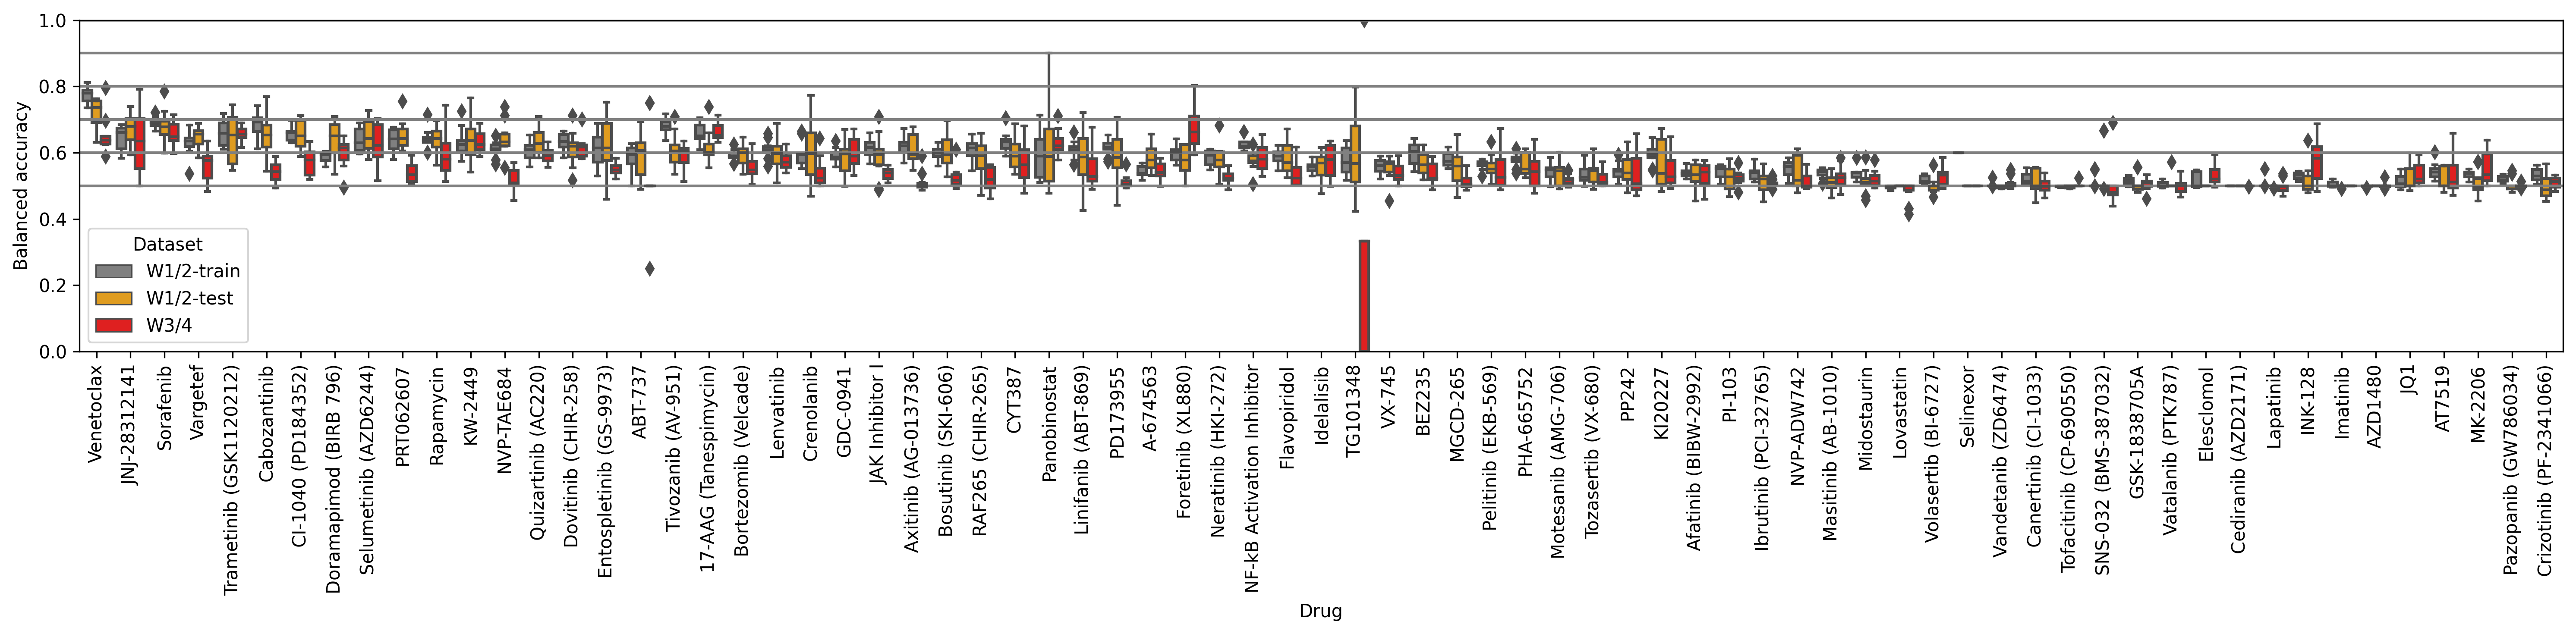

In [145]:
import seaborn as sns
#plt.figure(figsize = (20,3),dpi = 300)
acc_df = pd.DataFrame({"Drug":list(selected_r['Drug'])+ list(selected_r['Drug']) + list(selected_r['Drug']),
                       "ACC":list(selected_r['ACC_train']) + list(selected_r['ACC1_2']) + list(selected_r['ACC_w3_4']),
                      ## "F1":list(selected_r['F1_train']) + list(selected_r['F1_w1_2']) + list(selected_r['F1_w3_4']),
                       "Dataset":['W1/2-train']*len(selected_r) + ['W1/2-test']*len(selected_r) + ['W3/4']*len(selected_r)})

#acc_df = pd.DataFrame({"Drug": list(selected_r['Drug']) + list(selected_r['Drug']),
#                       "ACC": list(selected_r['ACC1_2']) + list(selected_r['ACC_w3_4']),
#                       "F1": list(selected_r['F1_w1_2']) + list(selected_r['F1_w3_4']),
#                       "Dataset": ['W1/2-test']*len(selected_r) + ['W3/4']*len(selected_r)})

### F1                 
### ACC

plt.figure(figsize = (20,5),dpi = 300)

sns.boxplot(x="Drug", y="ACC",
            hue="Dataset", palette=["grey",'orange', "red"],
            order = order_drugs['Drug'],
            data=acc_df)

#plt.ylim(0,1)
#plt.title(Drug.split("(")[0])
plt.xticks(range(0,len(order_drugs['Drug'])), order_drugs['Drug'], rotation = 90)
plt.ylim(0,1)

#plt a line for y = 0.8
plt.axhline(y = 0.5, color = 'gray', linestyle = '-')
plt.axhline(y = 0.6, color = 'gray', linestyle = '-')
plt.axhline(y = 0.7, color = 'gray', linestyle = '-')
plt.axhline(y = 0.8, color = 'gray', linestyle = '-')
plt.axhline(y = 0.9, color = 'gray', linestyle = '-')
plt.axhline(y = 1, color = 'gray', linestyle = '-')

plt.ylabel("Balanced accuracy")
plt.tight_layout()
plt.savefig("Balanced_accuracy_gene_expression_all.pdf", dpi=300)
#plt.show()

In [123]:
feature_drug_df = pd.DataFrame()
for drug in order_drugs['Drug']:
    print(drug)
    test = result_with_threshod[drug]
    #print(test)
    #print(sele_threshold[drug])
    cur = test[sele_threshold[drug]]
    #print(cur)
    feature_df = pd.DataFrame()
    for random in cur:
        if cur[random]['balanced_acc_training'] > 0.7 :
            feature_df_cur = cur[random]['features']
            feature_df_cur["IMP_"+str(random)]  = feature_df_cur['IMP']
            feature_df_cur.index = feature_df_cur['Feature']
            feature_df = pd.concat([feature_df, feature_df_cur["IMP_"+str(random)] ], axis =1)
    feature_df_sum = feature_df.sum(axis = 1)/feature_df.shape[1]
    result = pd.DataFrame({"features":feature_df_sum.index, 
                           "IMP":feature_df_sum.values, 
                           "Drug":[drug]*len(feature_df_sum.index)})
    
    feature_drug_df = pd.concat([feature_drug_df, result])

Sorafenib
Vargetef
Cabozantinib
CI-1040 (PD184352)
PRT062607
KW-2449
NVP-TAE684
Entospletinib (GS-9973)
ABT-737
Tivozanib (AV-951)
17-AAG (Tanespimycin)
Bortezomib (Velcade)
Lenvatinib
Crenolanib
GDC-0941
JAK Inhibitor I
Axitinib (AG-013736)
Bosutinib (SKI-606)
RAF265 (CHIR-265)
CYT387
Linifanib (ABT-869)
PD173955
A-674563
Neratinib (HKI-272)
NF-kB Activation Inhibitor
Idelalisib
TG101348
VX-745
MGCD-265
Pelitinib (EKB-569)
PHA-665752
Motesanib (AMG-706)
Tozasertib (VX-680)
KI20227
Afatinib (BIBW-2992)
Ibrutinib (PCI-32765)
NVP-ADW742
Masitinib (AB-1010)
Midostaurin
AT7519
Tofacitinib (CP-690550)
Cediranib (AZD2171)
Canertinib (CI-1033)
Volasertib (BI-6727)
Selinexor
Vandetanib (ZD6474)
Lovastatin
Vatalanib (PTK787)
Imatinib
AZD1480
JQ1
Lapatinib
GSK-1838705A
MK-2206
Pazopanib (GW786034)
Crizotinib (PF-2341066)


In [125]:
sympol_list = []
for feature in feature_drug_df['features']:
    sympol_list.append(dic_gene_map[feature])

feature_drug_df['sympol'] = sympol_list

In [126]:
feature_drug_df.loc[feature_drug_df['Drug'] == Drug].sort_values(by = ['IMP'], ascending = False).head(30)
feature_drug_df.to_csv("IMP_Feature_matrix_acc_gt0.7_ExpressionOlyg_remain.csv")

In [150]:
feature_drug_df1 = pd.read_csv("IMP_Feature_matrix_acc_gt0.7_ExpressionOlyg.csv", index_col = "Unnamed: 0")
feature_drug_df_test = pd.concat([feature_drug_df,feature_drug_df1])
feature_drug_df_test.to_csv("IMP_Feature_matrix_acc_gt0.7_ExpressionOlyg_all.csv")

In [151]:
feature_drug_df.loc[feature_drug_df['Drug'] == "Venetoclax"].sort_values(by = ['IMP'], ascending = False).head(30)
'BCL2' in set(feature_drug_df.loc[feature_drug_df['IMP']>0]['sympol'].values)

feature_drug_df.loc[feature_drug_df['sympol'] == "BCL2" ]


,features,IMP,Drug,sympol
